In [1]:
## question 1
# generate spikes for 10s using a Poisson spike generator
# constant rate: 100Hz
# record the time of occurrence
# compute the coefficient of variation of the interspike intervals
# compute the fano factor for spike counts of a counting window from 1 to 100 ms
# plot the interspike interval histogram


In [1]:
# solution: generate spike time t_i+1 = t_i - ln(x_rand)/r

In [2]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt

In [3]:
totalTime = 100
firingRate = 100

In [34]:
class spikeGen:
    
    def __init__(self,rate, time):
        # rate: constant firing rate
        # time: running time
        # spike_time: registered spike time
        # time_int: interspike time interval
        self.rate = rate
        self.time = time
        self.spike_time = np.zeros((1, (self.rate*self.time+1000)))
        self.time_int = np.zeros((1, (self.rate*self.time+1000)))
        self.fano_factor = np.nan
        self.coeff_var = np.nan
        
    def gen(self):
        # generate a spike train
        currTime = 0
        currInd = 0
        while currTime < self.time:
            randNum = random.random()

            t_int = - math.log(randNum) / self.rate

            self.time_int[0, currInd] = t_int
            self.spike_time[0, currInd] = currTime + t_int

            currTime += t_int
            currInd += 1

        # delete the zeros in the end of the array
        self.time_int = self.time_int[self.time_int!=0]
        self.spike_time = self.spike_time[self.spike_time!=0]
    
    def coeff_variance(self):
        # compute the coefficient of variance
        self.coeff_var = np.std(self.time_int) / np.mean(self.time_int)
    
    def fano(self,window):
        # compute the fano factor
        # window: time bin to count the spikes
        spikeCount = np.zeros((1, math.ceil(self.time/window)))
        ind = 0
        for i in np.arange(0, self.time, window):
            spikeCount[0, ind] = ((self.spike_time>=i)*(self.spike_time<i+window)).sum()
            ind += 1

        self.fano_factor = (np.std(spikeCount))**2 / np.mean(spikeCount)



In [35]:
# initiate an instance
spikeTrain1 = spikeGen(firingRate, totalTime)
# generate a spike train
spikeTrain1.gen()


In [36]:
# compute the coefficient of variance of interspike times
# C_v = sd/mean

spikeTrain1.coeff_variance()
print("The coefficient of variance of interspike times is ")
print(spikeTrain1.coeff_var)

The coefficient of variance of interspike times is 
1.0005785876066753


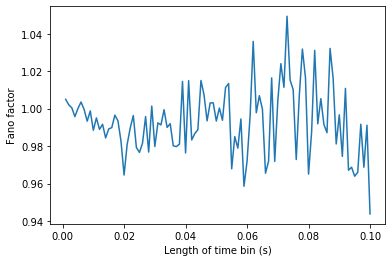

In [37]:
# compute the fano factor of spike counts in windows from 1 to 100 ms
# fano factor = var/mean
timeBin = np.array(range(1,101,1))/1000 # convert to s
fanoFac = np.zeros((1, len(timeBin)))
fanoInd = 0
for abin in timeBin:
    spikeTrain1.fano(abin)

    fanoFac[0,fanoInd] = spikeTrain1.fano_factor

    fanoInd += 1

# plot the fano factor
plt.figure(1)
plt.plot(timeBin, fanoFac[0,:])
plt.xlabel('Length of time bin (s)')
plt.ylabel('Fano factor')
plt.show()

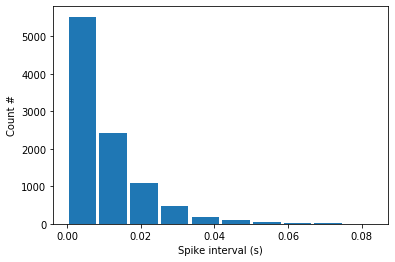

In [38]:
# plot the interspike interval histogram
plt.figure(2)
plt.hist(spikeTrain1.time_int, rwidth=0.9)
plt.xlabel('Spike interval (s)')
plt.ylabel('Count #')
plt.show()


In [1]:
## question 2 
# refractory period
# after spike, r = 0
# recovery: tau_ref*dr/dt = r_0 - r
# tau_ref in 1ms - 20 ms
# coefficient of variance
# interspike interval histogram for a few different tau
# fano factor for tau = 10ms, over counting window from 1 ms to 100 ms


In [4]:
# solution
# 1. spike generator with constant r_0
# rejecting sampling / spike thinning
# reject a spike if r_est(t_i)/r_0 < x_rand
# r_est = r_0 - exp(-(t-tauln(r_0)/tau)

In [44]:
r_0 = 100
totalTime = 10


In [68]:
# a child class with changing firing rate
class spikeGenRate(spikeGen):
    
    # only support exponentially recover rate now
    def __init__(self,maxrate,tau,time):
        spikeGen.__init__(self,maxrate,time)
        self.tau = tau
    
    def det_rate(self,t1,t2):
        # calculate firing rate at time t2 following a given spike at time t1
        rate_est = self.rate- math.exp(-(t2-t1-self.tau*math.log(r_0))/self.tau)
        return rate_est
        
    def spike_thin(self):
        
        if np.all((self.spike_time == 0)):
            print("Run generator function first!")
        else:
            # run spike thinning    
            #print(len(self.spike_time))
            for i in range(len(self.spike_time)-1):
                r_est = self.det_rate(self.spike_time[i], self.spike_time[i+1])
                x_rand = random.random()
                if x_rand > r_est/self.rate:
                    np.delete(self.spike_time,i+1)
                    np.delete(self.time_int,i+1)
                    

The coefficient of variance for tau = 1 ms is: 0.9983625050078562


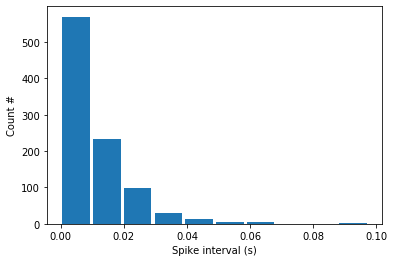

The coefficient of variance for tau = 5 ms is: 1.0279354724162058


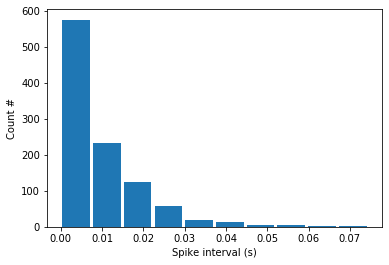

The coefficient of variance for tau = 10 ms is: 1.0581417112238733


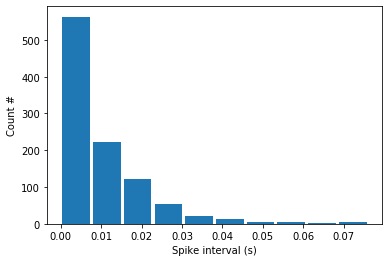

The coefficient of variance for tau = 15 ms is: 1.0118304732176366


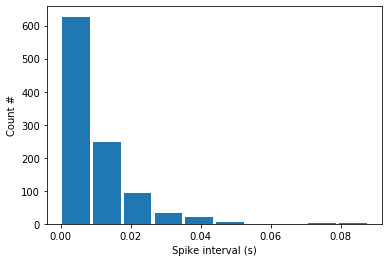

The coefficient of variance for tau = 20 ms is: 1.0145352269450563


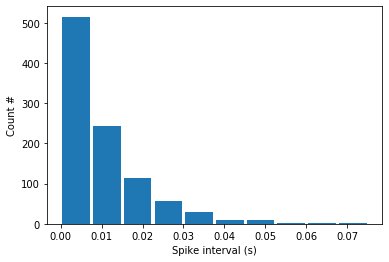

In [78]:
# calculate the coefficient of covariance for tau = 1,5,10,15,20
# and interspike interval histogram
tauList = [1, 5, 10, 15,20]
for tau in tauList:
    spikeTrain2 = spikeGenRate(r_0, tau,totalTime)
    spikeTrain2.gen()
    spikeTrain2.spike_thin()
    spikeTrain2.coeff_variance()

    s = 'The coefficient of variance for tau = ' + repr(tau)+ ' ms is: ' + repr(spikeTrain2.coeff_var)
    print(s)
    
    plt.figure()
    plt.hist(spikeTrain2.time_int, rwidth=0.9)
    plt.xlabel('Spike interval (s)')
    plt.ylabel('Count #')
    plt.show()


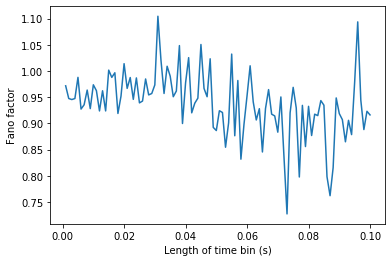

In [79]:
# fano factor
tau = 10
spikeTrain3 = spikeGenRate(r_0, tau,totalTime)
spikeTrain3.gen()
spikeTrain3.spike_thin()
    
timeBin = np.array(range(1,101,1))/1000 # convert to s
fanoFac2 = np.zeros((1, len(timeBin)))
fanoInd = 0
for abin in timeBin:
    spikeTrain3.fano(abin)

    fanoFac[0,fanoInd] = spikeTrain3.fano_factor

    fanoInd += 1

# plot the fano factor
plt.figure()
plt.plot(timeBin, fanoFac[0,:])
plt.xlabel('Length of time bin (s)')
plt.ylabel('Fano factor')
plt.show()
